In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [1]:
import re
import os
import ast
import json
import wandb
import unicodedata
import pandas as pd
from pathlib import Path
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import sys
sys.path.append("../../src")
sys.path.append("../../configs")
import util.preprocessing_util as util
from hf_config import hf_token

**Check versions of important packages**

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


**Check which python we are using**

In [93]:
print(sys.executable)

/share/miniforge3/bin/python3.10


**Load the data**

In [94]:
DATA_DIR = Path("../../data")
SYNTHETIC_TRAIN_DATA_DIR = DATA_DIR / "synthetic" / "questions"
TEST_DATA_DIR = DATA_DIR / "dev" / "processed"

TRAIN_DATA_FILE_NAME = "generated_questions_RUN01.csv"
TEST_DATA_FILE_NAME = "medical_data.csv"

MODELS_DIR = Path("../../models/")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [95]:
train_data = pd.read_csv(SYNTHETIC_TRAIN_DATA_DIR / TRAIN_DATA_FILE_NAME)
test_data = pd.read_csv(TEST_DATA_DIR / TEST_DATA_FILE_NAME)

Sentences and labels are still stringified lists --> back to actual Python lists

In [96]:
train_data["sentences"] = train_data["sentences"].apply(ast.literal_eval)
train_data["labels"] = train_data["labels"].apply(ast.literal_eval)

test_data["sentences"] = test_data["sentences"].apply(ast.literal_eval)
test_data["labels"] = test_data["labels"].apply(ast.literal_eval)

**TO BE REMOVED LATER - WE ALREADY DO THIS IN Q-GENERATION**

In [97]:
train_data = train_data[[
    "patient_question",
    "clinician_question",
    "sentences",
    "note_excerpt",
    "labels"
]]

# Exploration

In [98]:
train_data.head(3)

,patient_question,clinician_question,sentences,note_excerpt,labels
0,I had surgery for a kidney tumor and then got ...,What was the etiology of the patient’s postope...,[surgical pathology consult the patient a 72ye...,surgical pathology consult the patient a 72yea...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]"
1,I have kidney problems and high blood pressure...,What is the relationship between the patient's...,[admission date the patient arrived on 471830 ...,admission date the patient arrived on 471830 w...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
2,"I am worried about infection, and I live alone...",What are the key discharge instructions regard...,[postoperative assessment patient underwent ex...,postoperative assessment patient underwent exp...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [99]:
test_data.head(3)

,case_id,patient_question,clinician_question,note_excerpt,sentences,sentence_text,labels
0,1,My question is if the sludge was there does no...,Why was ERCP recommended to him over continuin...,Brief Hospital Course: During the ERCP a pancr...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course:,"[0, 1, 0, 0, 0, 1, 1, 1, 0]"
1,2,dad given multiple shots of lasciks after he w...,Why was he given lasix and his oxygen flow rat...,Brief Hospital Course: Acute diastolic heart f...,"[Brief Hospital Course:, Acute diastolic heart...",Brief Hospital Course:,"[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
2,3,he is continously irritated and has headache w...,What is the expected course of recovery for him?,Discharge Instructions: You were admitted to t...,[Discharge Instructions: You were admitted to ...,Discharge Instructions: You were admitted to t...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"


In [100]:
train_data

,patient_question,clinician_question,sentences,note_excerpt,labels
0,I had surgery for a kidney tumor and then got ...,What was the etiology of the patient’s postope...,[surgical pathology consult the patient a 72ye...,surgical pathology consult the patient a 72yea...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]"
1,I have kidney problems and high blood pressure...,What is the relationship between the patient's...,[admission date the patient arrived on 471830 ...,admission date the patient arrived on 471830 w...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
2,"I am worried about infection, and I live alone...",What are the key discharge instructions regard...,[postoperative assessment patient underwent ex...,postoperative assessment patient underwent exp...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Why do I have to take so many medications?,What is the rationale for the patient's curren...,[### Impression and Plan patient is a 65yearol...,### Impression and Plan patient is a 65yearold...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,I am confused about all these heart and kidney...,What is the rationale for initiating sacubitri...,"[physical exam on admission, the patient is a ...",physical exam on admission the patient is a 74...,"[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]"
...,...,...,...,...,...
295,Why was I given medication for my blood pressu...,What is the rationale for continuing losartan ...,[surgical procedure summary under went laminec...,surgical procedure summary under went laminect...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
296,"My mom was really uncomfortable at the end, wh...",What interventions were used to manage the pat...,[history of present illness patient known as m...,history of present illness patient known as ms...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
297,I was feeling really down during the hospital ...,What is the plan for titration of the patient’...,[major surgical or invasive procedure subtotal...,major surgical or invasive procedure subtotal ...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]"
298,I’m worried about the cells they found. What d...,What is the differential diagnosis given the a...,[the patient underwent ct imaging which reveal...,the patient underwent ct imaging which reveale...,"[0, 0, 0, 0, 0, 1, 1, 0]"


# Aggregate 

In [101]:
'''
train_data_agg = (
    train_data[
        ['note_excerpt', 'patient_question', 'clinician_question', 'sentences', 'labels']
    ]
    .assign(sentences_full=lambda df: df['sentences'])
    .explode(['sentences', 'labels'])
    .rename(columns={'sentences': 'sentence', 'labels': 'label'})
    .reset_index(drop=True)
)
train_data_agg = train_data_agg.rename(columns={'sentences_full': 'sentences'})

test_data_agg = (
    test_data[
        ['note_excerpt', 'patient_question', 'clinician_question', 'sentences', 'labels']
    ]
    .assign(sentences_full=lambda df: df['sentences'])
    .explode(['sentences', 'labels'])
    .rename(columns={'sentences': 'sentence', 'labels': 'label'})
    .reset_index(drop=True)
)
test_data_agg = test_data_agg.rename(columns={'sentences_full': 'sentences'})
''';

# Masking

We’ll create one row per sentence: full context + label for only that sentence

And add **[START]** and **[END]** markers around the target sentence

In [102]:
WINDOW_SIZE = 0

In [103]:
train_data_masked = util.mask_on_sentence_level(train_data, window=WINDOW_SIZE)
test_data_masked = util.mask_on_sentence_level(test_data, window=WINDOW_SIZE)

In [104]:
train_data_masked.head()

,question,context,target_sentence,target_index,label
0,I had surgery for a kidney tumor and then got ...,surgical pathology consult the patient a 72yea...,surgical pathology consult the patient a 72yea...,0,0
1,I had surgery for a kidney tumor and then got ...,history includes stage 2 breast cancer sp lump...,history includes stage 2 breast cancer sp lump...,1,0
2,I had surgery for a kidney tumor and then got ...,the renal mass raised suspicion for malignancy...,the renal mass raised suspicion for malignancy...,2,0
3,I had surgery for a kidney tumor and then got ...,pathology report confirmed clear cell renal ca...,pathology report confirmed clear cell renal ca...,3,0
4,I had surgery for a kidney tumor and then got ...,patient was then referred to medical oncology ...,patient was then referred to medical oncology ...,4,0


In [107]:
train_data_masked['label'].value_counts()

label
0    3299
1     857
Name: count, dtype: int64

In [108]:
test_data_masked['label'].value_counts()

label
0    290
1    138
Name: count, dtype: int64

In [105]:
test_data_masked.head()

,question,context,target_sentence,target_index,label
0,My question is if the sludge was there does no...,Brief Hospital Course:,Brief Hospital Course:,0,0
1,My question is if the sludge was there does no...,During the ERCP a pancreatic stent was require...,During the ERCP a pancreatic stent was require...,1,1
2,My question is if the sludge was there does no...,"However, due to the patient's elevated INR, no...","However, due to the patient's elevated INR, no...",2,0
3,My question is if the sludge was there does no...,Frank pus was noted to be draining from the co...,Frank pus was noted to be draining from the co...,3,0
4,My question is if the sludge was there does no...,The Vancomycin was discontinued.,The Vancomycin was discontinued.,4,0


# Undersample Class 0

In [109]:
df = train_data_masked.copy()

# split positives & negatives
df_pos = df[df.label == 1]
df_neg = df[df.label == 0]

# undersample negatives 1:1 to positives
df_neg_sub = df_neg.sample(n=len(df_pos), random_state=1050)

# recombine & shuffle
df_balanced = pd.concat([df_pos, df_neg_sub], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=1050).reset_index(drop=True)

print("New class balance:")
print(df_balanced.label.value_counts())

New class balance:
label
0    857
1    857
Name: count, dtype: int64


In [110]:
train_data_masked = df_balanced

In [112]:
train_data_masked.head()

,question,context,target_sentence,target_index,label
0,"Is it possible this is not a heart problem, bu...",stay hydrated and maintain a balanced diet to ...,stay hydrated and maintain a balanced diet to ...,15,0
1,Is it okay to start smoking again if I feel be...,smoking cessation resources given and encouraged,smoking cessation resources given and encouraged,12,1
2,"I was taking a blood thinner before surgery, a...",co-management with hematology for evaluation o...,co-management with hematology for evaluation o...,10,0
3,"I have diabetes, and my A1C is high. What can ...",she was advised to monitor her blood pressure ...,she was advised to monitor her blood pressure ...,9,1
4,"I was confused and could barely walk, and my k...",hypertension,hypertension,3,0


# Dataset Preperation

- Fine-tuning both the model weights and using a tokenizer whose vocabulary matches your task/domain.

- All components — embeddings, encoder layers, and classifier head — are updated during training.

**Configs**

In [113]:
MODEL = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
BATCH_SIZE = 64
CONTEXT_LENGTH = 512

In [114]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, token=hf_token)

**Load trainable embeddings**

In [115]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, token=hf_token
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
# Resize model embeddings to match new special tokens
if WINDOW_SIZE > 0:
    special_tokens = {"additional_special_tokens": ["[START]", "[END]"]}
    tokenizer.add_special_tokens(special_tokens);
    model.resize_token_embeddings(len(tokenizer))

Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [117]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

**Prepare the dataset**

In [118]:
dataset_train = Dataset.from_pandas(train_data_masked)
dataset_test = Dataset.from_pandas(test_data_masked)

In [119]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/2142 [00:00<?, ?it/s]

In [120]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [121]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Map:   0%|          | 0/1714 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

In [122]:
progress_bar.close()

**Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)**

In [123]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

**Create DataLoader for Batching**

In [124]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

Check one batch

In [125]:
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([64, 512]), 'attention_mask': torch.Size([64, 512]), 'labels': torch.Size([64])}


**Sanity check to verify that everything is correct before training**

In [126]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1714
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 428
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']


# Training

**Define directory for temporary checkpoints**

In [127]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

**Define training arguments & initialize trainer**

In [128]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
DATASET_NAME = "synthetic-V1"

WANDB_PROJECT_NAME = "Sythetic-Med"
WANDB_RUN_NAME = f"BioMedBert-SyntheticV1-RunV1"
WANDB_NOTEBOOK_NAME = "train_and_eval"

**Setup W&B**

In [129]:
os.environ["WANDB_NOTEBOOK_NAME"] = WANDB_NOTEBOOK_NAME
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [130]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture=MODEL,
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with [START]/[END]"
)

**Generate run-id to resume same run after training**

In [131]:
run_id = wandb.util.generate_id()

In [132]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.67757


In [133]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

In [134]:
import transformers
print(transformers.__version__)

4.51.3


In [135]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    eval_strategy="steps",                        # Evaluate every N steps
    eval_steps=100,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=250,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)

In [136]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=4)] # Prevent overfitting by stopping when eval loss stops improving
)

**Make sure we are using the GPU**

In [137]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A100-SXM4-80GB


In [138]:
model.to("cuda");

In [139]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=81, training_loss=0.5878026043927228, metrics={'train_runtime': 21.4383, 'train_samples_per_second': 239.851, 'train_steps_per_second': 3.778, 'total_flos': 1352917046661120.0, 'train_loss': 0.5878026043927228, 'epoch': 3.0})

**Save the model (optional)**

In [140]:
model.save_pretrained(MODELS_DIR)
tokenizer.save_pretrained(MODELS_DIR)

('../../models/tokenizer_config.json',
 '../../models/special_tokens_map.json',
 '../../models/vocab.txt',
 '../../models/added_tokens.json',
 '../../models/tokenizer.json')

# Evaluation

## Configurations

In [141]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

train/epoch,▁
train/global_step,▁
total_flos,1352917046661120.0
train/epoch,3
train/global_step,81
train_loss,0.5878
train_runtime,21.4383
train_samples_per_second,239.851
train_steps_per_second,3.778


In [142]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [143]:
label_names = ["Not Relevant", "Essential"]

In [144]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.702541,0.577103,0.382253,0.36129,0.405797,0.3993,1071.86,10.017,3.0


## Classification Report

In [145]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.699634,0.658621,0.678508,290.000000
1,0.361290,0.405797,0.382253,138.000000
accuracy,0.577103,0.577103,0.577103,0.577103
macro avg,0.530462,0.532209,0.530380,428.000000
weighted avg,0.590542,0.577103,0.582986,428.000000


## Confusion Matrix

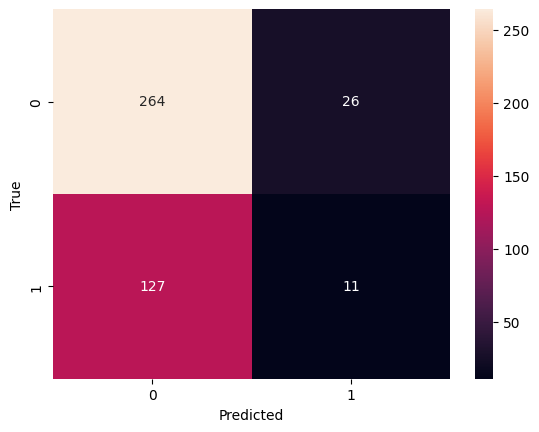

In [46]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Persisting Results

In [47]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

**Step-1: Locally**

In [48]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

**Step-2: Wandb**

In [49]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})

In [50]:
wandb.finish()

eval/accuracy,▁▁
eval/f1,▁
eval/f1_class_0,▁
eval/f1_class_1,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁
eval/recall_class_1,▁
eval/runtime,▁
